In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
%matplotlib inline

2023-09-04 22:33:38.113436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# base path to the input dataset 
BASE_PATH = "./solid_dataset_od"

# path to the input images and annotation CSV files
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

image_width, image_height = 200, 200

initialize the list of data (images), class labels, target bounding box coordinates, and image paths

In [7]:
data = []
labels = []
bboxes = []
imagePaths = []

In [8]:
csvPaths = []
for (rootDir, dirNames, filenames) in os.walk(ANNOTS_PATH):
    for filename in filenames:
        # file extension
        ext = filename[filename.rfind("."):].lower()

        if ext.endswith(".csv"):
            csvPath = os.path.join(rootDir, filename)
            csvPaths.append(csvPath)
csvPaths

['./solid_dataset_od/annotations/W.csv',
 './solid_dataset_od/annotations/V.csv',
 './solid_dataset_od/annotations/A.csv',
 './solid_dataset_od/annotations/C.csv',
 './solid_dataset_od/annotations/T.csv',
 './solid_dataset_od/annotations/U.csv',
 './solid_dataset_od/annotations/B.csv',
 './solid_dataset_od/annotations/Q.csv',
 './solid_dataset_od/annotations/F.csv',
 './solid_dataset_od/annotations/G.csv',
 './solid_dataset_od/annotations/P.csv',
 './solid_dataset_od/annotations/R.csv',
 './solid_dataset_od/annotations/E.csv',
 './solid_dataset_od/annotations/D.csv',
 './solid_dataset_od/annotations/S.csv',
 './solid_dataset_od/annotations/I.csv',
 './solid_dataset_od/annotations/H.csv',
 './solid_dataset_od/annotations/J.csv',
 './solid_dataset_od/annotations/K.csv',
 './solid_dataset_od/annotations/O.csv',
 './solid_dataset_od/annotations/X.csv',
 './solid_dataset_od/annotations/Y.csv',
 './solid_dataset_od/annotations/N.csv',
 './solid_dataset_od/annotations/L.csv',
 './solid_datase

In [9]:
# loop all CSV files in annotations 
for csvPath in csvPaths:
    rows = open(csvPath).read().strip().split("\n")

    for row in rows:
        # row = the filename, bounding box coordinates, class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # path to the input image
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        # load the image in OpenCV
        image = cv2.imread(imagePath)
        # dimension of the image
        (h, w) = image.shape[:2]

        # scale the bounding box coords relative to the spatial dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess
        image = load_img(imagePath, target_size = (image_width, image_height))
        image = img_to_array(image)

        # update the list of data, class labels, bounding boxes, image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

In [10]:
# convert the data, class labels, bounding boxes, and image paths to NumPy arrays
# scaling the input pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

In [11]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [12]:
# train (80%) & test (20%) splits
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths,  testPaths)  = split[6:]

In [13]:
# load the VGG16 network
vgg = VGG16(weights="imagenet", 
            include_top=False, 
            input_tensor = Input(shape = (image_width, image_height, 3)))

In [14]:
# freeze all VGG layers (not be updated during the training process)
vgg.trainable = False

In [15]:
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# input: image, output: bounding box coordinates & a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

In [16]:
# dictionary of the loss
# class label head : categorical cross-entropy
# bounding box head: mean absolute error
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# dictionary of weights per loss: class label & bounding box outputs ( receive equal weight
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [17]:
# initialize the optimizer, compile the model, and show the model summary
opt = Adam(lr = 1e-4)
model.compile(loss = losses,
              optimizer = opt, 
              metrics = ["accuracy"], 
              loss_weights = lossWeights)

In [18]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

# train the network for bounding box regression and class label prediction
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1)

Epoch 1/20
 1/14 [=>............................] - ETA: 1:17 - loss: 3.6117 - bounding_box_loss: 0.0870 - class_label_loss: 3.5247 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.0625

KeyboardInterrupt: 

In [ ]:
model.save('3.h5', save_format="h5")
with open('lb3.pickle', "wb") as f:
    f.write(pickle.dumps(lb))

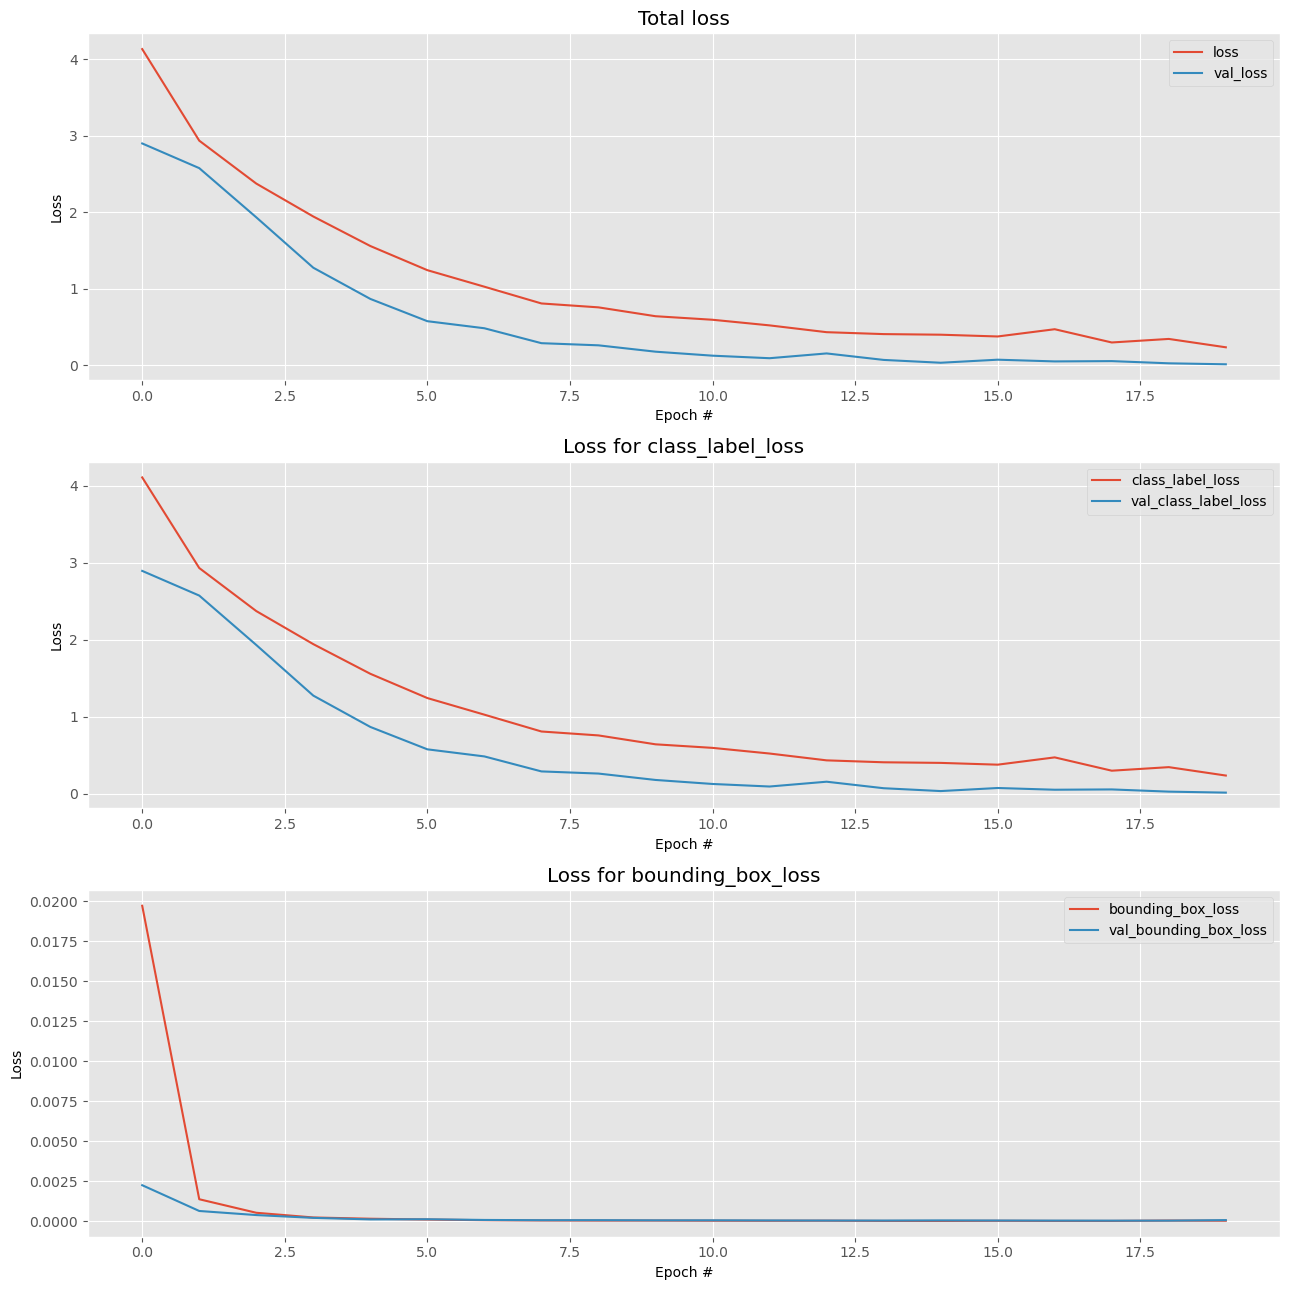

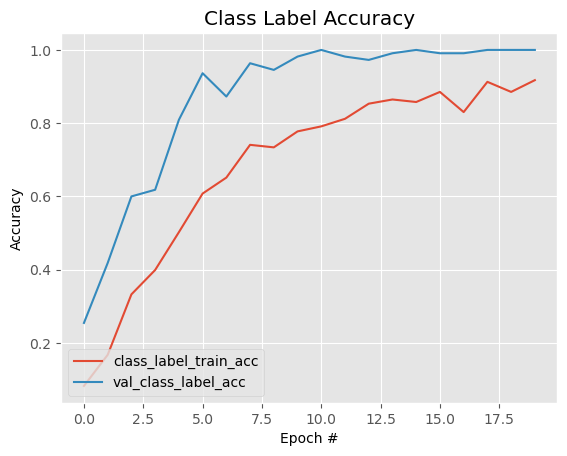

In [16]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, H.params['epochs'])
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")